In [32]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline

In [33]:
with open('transaction-data-adhoc-analysis.json', 'r') as f:
    data = json.load(f)

In [34]:
df = pd.DataFrame(data)

In [35]:
#drop NaN values (if any)
df.dropna(inplace=True)

In [36]:
#data cleanup. splits items
df["transaction_items"] = df["transaction_items"].str.split(";")

In [37]:
#separates items
df = df.explode("transaction_items")

In [38]:
#cleanup. splits transaction items into [item, count], assigns new count column to dump count and formats in int. cleans transaction items column, makes everything in this format (eg: Exotic Extras: Beef Chicharon)
df["transaction_items"] = df["transaction_items"].str.split("(")
df["count"] = df["transaction_items"].str[1]
df["transaction_items"] = df["transaction_items"].str[0]
df["count"] = df["count"].str[1]
df["count"] = df["count"].astype(int)
df["transaction_items"] = df["transaction_items"].str.replace(",", ": ")
df["transaction_items"] = df["transaction_items"].str[:-2]

In [39]:
#look for duplicated indices. creates an array of non-duplicated indices
duplicates = np.array(list(df.index.duplicated(keep = False)))
non_duplicates = np.where(duplicates == False)[0]

In [40]:
#resets index. wasn't reset in explode function so that i could look for the duplicated incdices
df.reset_index(inplace = True)

In [41]:
#slices df, non-duplicated rows
non_duplicates_df= df.loc[non_duplicates]

In [42]:
#further slices the df, keeps first instance of transaction item
non_duplicates_df = non_duplicates_df.loc[non_duplicates_df.duplicated(subset = "transaction_items", keep = "first") == False]

In [43]:
#solve for the price per item (can only be done in cases where customers bought solely one type of item, hence the use and search for a non-duplicated array)
non_duplicates_df["price_per_item"] = non_duplicates_df["transaction_value"]/non_duplicates_df["count"]

In [44]:
#creates a dictionary [item, price]
prod_price = dict(zip(non_duplicates_df.transaction_items,non_duplicates_df.price_per_item))

In [45]:
#drop unnecessary columns
df.drop(columns = ["transaction_value", "index"], inplace= True)

In [46]:
#apply function was used, match value with key in transaction_items
df["price_per_item"] = df["transaction_items"].apply(lambda x: prod_price.get(x))

In [47]:
#get price_value
df["price_value"] = df["price_per_item"] * df["count"]

In [48]:
#get month through transaction date column
df["month"] = df["transaction_date"].str[6].astype(int)

In [49]:
#initialize pivot table
sales_per_month = pd.pivot_table(df, index = "transaction_items", columns = "month", values = "price_value", aggfunc = "sum")

In [50]:
#format in millions of pesos
sales_per_month[1] = (sales_per_month[1]/1000000).apply(lambda x: '₱{:,.2f}M'.format(x))
sales_per_month[2] = (sales_per_month[2]/1000000).apply(lambda x: '₱{:,.2f}M'.format(x))
sales_per_month[3] = (sales_per_month[3]/1000000).apply(lambda x: '₱{:,.2f}M'.format(x))
sales_per_month[4] = (sales_per_month[4]/1000000).apply(lambda x: '₱{:,.2f}M'.format(x))
sales_per_month[5] = (sales_per_month[5]/1000000).apply(lambda x: '₱{:,.2f}M'.format(x))
sales_per_month[6] = (sales_per_month[6]/1000000).apply(lambda x: '₱{:,.2f}M'.format(x))

In [51]:
sales_per_month

month,1,2,3,4,5,6
transaction_items,,,,,,
Candy City: Gummy Worms,₱1.43M,₱1.50M,₱1.50M,₱1.51M,₱1.47M,₱1.49M
Candy City: Orange Beans,₱1.95M,₱2.00M,₱1.91M,₱1.97M,₱1.98M,₱2.01M
Exotic Extras: Beef Chicharon,₱12.55M,₱12.99M,₱12.75M,₱12.85M,₱13.03M,₱12.86M
Exotic Extras: Kimchi and Seaweed,₱7.73M,₱7.95M,₱7.96M,₱7.93M,₱7.81M,₱8.07M
HealthyKid 3+: Gummy Vitamins,₱14.52M,₱14.97M,₱15.22M,₱14.76M,₱14.92M,₱14.97M
HealthyKid 3+: Nutrional Milk,₱19.36M,₱19.29M,₱19.65M,₱19.47M,₱19.66M,₱19.44M
HealthyKid 3+: Yummy Vegetables,₱4.98M,₱5.13M,₱4.95M,₱4.93M,₱4.87M,₱4.86M


In [52]:
#initialize pivot table
count_per_month = pd.pivot_table(df, index = "transaction_items", columns = "month", values = "count", aggfunc = "sum")
count_per_month

month,1,2,3,4,5,6
transaction_items,,,,,,
Candy City: Gummy Worms,9559,9996,9986,10043,9801,9934
Candy City: Orange Beans,9774,10037,9611,9914,9964,10106
Exotic Extras: Beef Chicharon,9665,10001,9816,9890,10028,9902
Exotic Extras: Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
HealthyKid 3+: Gummy Vitamins,9681,9980,10145,9842,9948,9980
HealthyKid 3+: Nutrional Milk,9727,9691,9876,9786,9881,9767
HealthyKid 3+: Yummy Vegetables,9959,10256,9896,9861,9735,9722


In [53]:
#initialize total sales per month (additional)
total_sales_per_month = pd.pivot_table(df, index = "month", values = "price_value", aggfunc = "sum")
total_sales_per_month["price_value"] = (total_sales_per_month["price_value"]/1000000).apply(lambda x: '₱{:,.2f}M'.format(x))
total_sales_per_month

,price_value
month,
1,₱62.52M
2,₱63.82M
3,₱63.94M
4,₱63.42M
5,₱63.74M
6,₱63.70M


In [54]:
#returns lists of all unique customers for a certain month. 
january_customers= df.loc[df['month'] == 1]["name"].unique()
february_customers= df.loc[df['month'] == 2]["name"].unique()
march_customers= df.loc[df['month'] == 3]["name"].unique()
april_customers= df.loc[df['month'] == 4]["name"].unique()
may_customers= df.loc[df['month'] == 5]["name"].unique()
june_customers= df.loc[df['month'] == 6]["name"].unique()

In [55]:
#returns lists of all repeaters for a certain month (through finding the set intersections of the previous month and the next month)
february_repeaters = np.intersect1d(january_customers, february_customers)
march_repeaters = np.intersect1d(february_customers, march_customers)
april_repeaters = np.intersect1d(march_customers, april_customers)
may_repeaters = np.intersect1d(april_customers, may_customers)
june_repeaters = np.intersect1d(may_customers, june_customers)
total_repeaters = np.array([len(february_repeaters), len(march_repeaters), len(april_repeaters), len(may_repeaters), len(june_repeaters)])

In [56]:
#assume that january is the start of the timeframe. adjust as is for future use. finds inactive customers by getting the set difference between the customers for a specific month and the total customers in the registry
total_customers_by_feb = np.union1d(january_customers, february_customers)
february_inactive = np.setdiff1d(total_customers_by_feb, february_customers) #set of all customers not in month
total_customers_by_mar = np.union1d(total_customers_by_feb, march_customers)
march_inactive = np.setdiff1d(total_customers_by_mar, march_customers) #set of all customers not in month
total_customers_by_apr = np.union1d(total_customers_by_mar, april_customers)
apr_inactive = np.setdiff1d(total_customers_by_apr, april_customers) #set of all customers not in month
total_customers_by_may = np.union1d(total_customers_by_apr, may_customers)
may_inactive = np.setdiff1d(total_customers_by_may, may_customers) #set of all customers not in month
total_customers_by_june = np.union1d(total_customers_by_may, june_customers)
june_inactive = np.setdiff1d(total_customers_by_june, june_customers) #set of all customers not in month
total_inactive = np.array([len(february_inactive), len(march_inactive), len(apr_inactive), len(may_inactive), len(june_inactive)])

In [57]:
#gets intersection of all sets (customers by month)
february_engaged = reduce(np.intersect1d, (january_customers, february_customers))
march_engaged = reduce(np.intersect1d, (january_customers, february_customers, march_customers))
apr_engaged = reduce(np.intersect1d, (january_customers, february_customers, march_customers, april_customers))
may_engaged = reduce(np.intersect1d, (january_customers, february_customers, march_customers, april_customers, may_customers))
june_engaged = reduce(np.intersect1d, (january_customers, february_customers, march_customers, april_customers, may_customers, june_customers))
total_engaged = np.array([len(february_engaged), len(march_engaged), len(apr_engaged), len(may_engaged), len(june_engaged)])

In [58]:
months= ["February", "March", "April", "May", "June"]

In [59]:
#creates dataframe for all metrics
total_df = pd.DataFrame({'Months': months, 'Repeaters Per Month': total_repeaters, 'Inactive Per Month': total_inactive, "Engaged Per Month": total_engaged})
total_df.set_index('Months')

,Repeaters Per Month,Inactive Per Month,Engaged Per Month
Months,,,
February,5172,1416,5172
March,5216,1747,4126
April,5154,1909,3289
May,5110,1917,2667
June,5193,1835,2190


In [60]:
#gets retention rate for customers. repeaters is used because it is the amount of customers in the previous month who were retained
february_retention = len(february_repeaters)/len(january_customers)
march_retention = len(march_repeaters)/len(february_customers)
april_retention = len(april_repeaters)/len(march_customers)
may_retention = len(may_repeaters)/len(april_customers)
june_retention = len(june_repeaters)/len(may_customers)
total_retention = [february_retention, march_retention, april_retention, may_retention, june_retention]

In [61]:
#gets retention rate for repeaters. ret_rate = 1- churn_rate. churn_rate is the amount of repeaters not retained in the next month, hence the use of the set difference function.
march_repeater_ret = 1 - (len(np.setdiff1d(february_repeaters, march_repeaters))/len(february_repeaters))
april_repeater_ret = 1 - (len(np.setdiff1d(march_repeaters, april_repeaters))/len(march_repeaters))
may_repeater_ret = 1 - (len(np.setdiff1d(april_repeaters, may_repeaters))/len(april_repeaters))
june_repeater_ret = 1- (len(np.setdiff1d(may_repeaters, june_repeaters))/len(may_repeaters))
total_repeater_ret = np.array([1, march_repeater_ret, april_repeater_ret, may_repeater_ret, june_repeater_ret])

In [63]:
#gets engagement retention rate. amount of engaged who were retained. did not use set diff anymore, as engaged is defined to be in all months.
february_engagement_ret = len(february_engaged)/len(february_engaged)
march_engagement_ret = len(march_engaged)/len(february_engaged)
april_engagement_ret = len(apr_engaged)/len(march_engaged)
may_engagement_ret = len(may_engaged)/len(apr_engaged)
june_engagement_ret = len(june_engaged)/len(may_engaged)
total_engagement_ret = [february_engagement_ret, march_engagement_ret, april_engagement_ret, may_engagement_ret, june_engagement_ret]

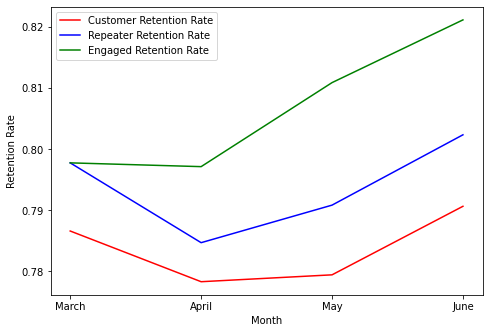

In [65]:
#plotting the retention rates
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(months[1:], total_retention[1:], 'r', label = "Customer Retention Rate")
ax.plot(months[1:], total_repeater_ret[1:], 'b', label = "Repeater Retention Rate")
ax.plot(months[1:], total_engagement_ret[1:], 'g', label = "Engaged Retention Rate")
plt.xlabel("Month")
plt.ylabel("Retention Rate")
plt.legend()
plt.show()

In [75]:
#growth rate. calculated by amount of customers by the end of the month subtracted by the amount of customers at the start, all over the amount of customers at the start
february_growth = (len(february_customers) - len(january_customers))/len(january_customers)
march_growth = (len(march_customers) - len(february_customers))/len(february_customers)
april_growth = (len(april_customers) - len(march_customers))/len(march_customers)
may_growth = (len(may_customers)-len(april_customers))/len(april_customers)
june_growth = (len(june_customers)-len(may_customers))/len(may_customers)

In [76]:
total_growth = [february_growth, march_growth, april_growth, may_growth, june_growth]

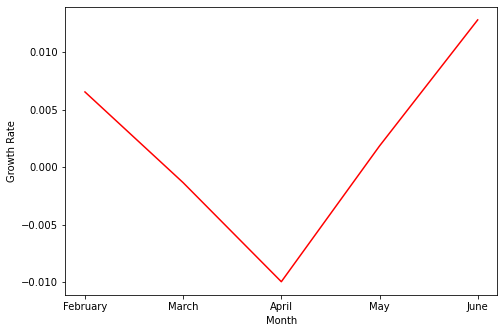

In [77]:
#growth rate plot
fig2 = plt.figure()
ax = fig2.add_axes([0,0,1,1])
ax.plot(months, total_growth, 'r', label = "GrowthRate")
plt.xlabel("Month")
plt.ylabel("Growth Rate")
plt.show()

In [66]:
#getting the year of birth for all customers, format as int for data manipulation
df["year"] = df["birthdate"].str[0:4].astype(int)

In [79]:
df

,address,birthdate,mail,name,sex,username,transaction_items,transaction_date,count,price_per_item,price_value,month,year
0,USNS Wagner\nFPO AE 00917,1926/03/11,watsonbrenda@gmail.com,Jennifer Campbell,F,veronicawells,Exotic Extras: Beef Chicharon,2022/01/12,4,1299.0,5196.0,1,1926
1,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,Exotic Extras: Beef Chicharon,2022/01/12,3,1299.0,3897.0,1,2016
2,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,HealthyKid 3+: Nutrional Milk,2022/01/12,4,1990.0,7960.0,1,2016
3,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,Candy City: Orange Beans,2022/01/12,1,199.0,199.0,1,2016
4,USCGC Benson\nFPO AP 48794,2016/07/08,moorelisa@gmail.com,Melissa Kim,F,cgilbert,HealthyKid 3+: Gummy Vitamins,2022/01/08,3,1500.0,4500.0,1,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166114,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,HealthyKid 3+: Nutrional Milk,2022/06/09,2,1990.0,3980.0,6,1913
166115,428 Kristopher Curve Apt. 206\nMcculloughville...,1913/11/04,melvinschmidt@hotmail.com,Donald Andersen,M,llowe,Candy City: Gummy Worms,2022/06/09,2,150.0,300.0,6,1913
166116,"PSC 1089, Box 3720\nAPO AE 08973",2012/04/30,xjones@hotmail.com,Stephanie Russell,F,cmcdowell,HealthyKid 3+: Nutrional Milk,2022/06/03,1,1990.0,1990.0,6,2012
166117,"PSC 1089, Box 3720\nAPO AE 08973",2012/04/30,xjones@hotmail.com,Stephanie Russell,F,cmcdowell,Candy City: Gummy Worms,2022/06/03,3,150.0,450.0,6,2012


In [67]:
#get all unique customers for each age demographic
genz_customers= df.loc[df["year"]>=1997]["name"].unique()
millenial_customers = df.loc[(df["year"]>= 1981) & (df["year"]<=1996)]["name"].unique()
genx_customers = df.loc[(df["year"]>= 1965) & (df["year"]<=1980)]["name"].unique()
boomer_customers = df.loc[(df["year"]>= 1945) & (df["year"]<=1964)]["name"].unique()
silentgen_customers = df.loc[(df["year"]<=1944)]["name"].unique()

In [68]:
#get percentage of age demographic by dividing length of demographic over the length of all customers in the registry
genz_percent = len(genz_customers)/len(total_customers_by_june)
millenial_percent = len(millenial_customers)/len(total_customers_by_june)
genx_percent = len(genx_customers)/len(total_customers_by_june)
boomer_percent = len(boomer_customers)/len(total_customers_by_june)
silentgen_percent = len(silentgen_customers)/len(total_customers_by_june)
pie_percents = [silentgen_percent, boomer_percent, genx_percent, millenial_percent, genz_percent]
labels = "Silent Generation", "Boomers", "Generation X", "Millenials", "Generation Z"

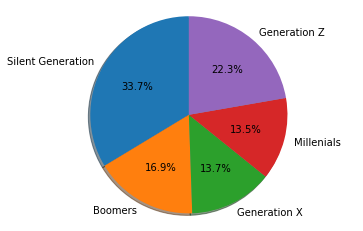

In [69]:
#pie chart plot
fig1, ax1 = plt.subplots()
ax1.pie(pie_percents, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

In [70]:
#pivot table, items preferred by genz
genz= df.loc[df["year"]>=1997]
genz_pivot = pd.pivot_table(genz, index = "transaction_items", values = "count", aggfunc = "sum")
genz_pivot.sort_values(by=["count"], ascending = False)

,count
transaction_items,
Candy City: Orange Beans,13559
Exotic Extras: Kimchi and Seaweed,13275
Candy City: Gummy Worms,13163
HealthyKid 3+: Yummy Vegetables,13140
HealthyKid 3+: Nutrional Milk,13109
HealthyKid 3+: Gummy Vitamins,13107
Exotic Extras: Beef Chicharon,13070


In [71]:
#pivot table, items preferred by millenials
millenials = df.loc[(df["year"]>= 1981) & (df["year"]<=1996)]
millenials_pivot = pd.pivot_table(millenials, index = "transaction_items", values = "count", aggfunc = "sum")
millenials_pivot.sort_values(by=["count"], ascending = False)

,count
transaction_items,
Exotic Extras: Kimchi and Seaweed,8140
HealthyKid 3+: Yummy Vegetables,8052
HealthyKid 3+: Gummy Vitamins,7844
Candy City: Gummy Worms,7815
Candy City: Orange Beans,7743
Exotic Extras: Beef Chicharon,7722
HealthyKid 3+: Nutrional Milk,7627


In [73]:
#pivot table, items preferred by genx
genx = df.loc[(df["year"]>= 1965) & (df["year"]<=1980)]
genx_pivot = pd.pivot_table(genx, index = "transaction_items", values = "count", aggfunc = "sum")
genx_pivot.sort_values(by=["count"], ascending = False)

,count
transaction_items,
HealthyKid 3+: Gummy Vitamins,8325
Candy City: Orange Beans,8150
Candy City: Gummy Worms,8076
Exotic Extras: Kimchi and Seaweed,8059
Exotic Extras: Beef Chicharon,8056
HealthyKid 3+: Yummy Vegetables,7980
HealthyKid 3+: Nutrional Milk,7943


In [74]:
#pivot table, items preferred by boomers
boomers = df.loc[(df["year"]>= 1945) & (df["year"]<=1964)]
boomers_pivot = pd.pivot_table(boomers, index = "transaction_items", values = "count", aggfunc = "sum")
boomers_pivot.sort_values(by=["count"], ascending = False)

,count
transaction_items,
Exotic Extras: Beef Chicharon,10324
HealthyKid 3+: Gummy Vitamins,10059
Candy City: Gummy Worms,10048
HealthyKid 3+: Yummy Vegetables,9912
Exotic Extras: Kimchi and Seaweed,9876
HealthyKid 3+: Nutrional Milk,9872
Candy City: Orange Beans,9774


In [78]:
#pivot table, items preferred by the silent generation
silentgen = df.loc[(df["year"]<=1944)]
silentgen_pivot = pd.pivot_table(silentgen, index = "transaction_items", values = "count", aggfunc = "sum")
silentgen_pivot.sort_values(by=["count"], ascending = False)

,count
transaction_items,
HealthyKid 3+: Yummy Vegetables,20345
HealthyKid 3+: Gummy Vitamins,20241
Candy City: Gummy Worms,20217
Candy City: Orange Beans,20180
HealthyKid 3+: Nutrional Milk,20177
Exotic Extras: Beef Chicharon,20130
Exotic Extras: Kimchi and Seaweed,20040
